 # ECM Preliminary Implementation
 This script builds a BLSTM classification model for annotation of a dataset
 generated from a Convokit Corpus. Most specifically, 'mentalhealth'
 Subreddit posts and replies.

In [1]:
from convokit import Corpus, download
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import sys, os, re, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from numpy import array
from collections import Counter

# NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('Libraries Loaded')


Libraries Loaded
[nltk_data] Downloading package punkt to /home/buddha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/buddha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/buddha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # Utilities and Functions
 This long block are functions, utilities and variables that help
 throughout the implementation that really starts next block.

In [2]:

# Text that invalidates the whole row.
rowInvalidationText = ['', ' ', '[deleted]', '[removed]']
# Additional stopwords
extraStopwords = set(
    ['reddit', 'redditor', 'reddits', 'subreddit', 'subreddits'])

emotionOther = ['love', 'surprise']

# Variables for cleaner() method
stemmer = PorterStemmer() # Stemmer
lem = WordNetLemmatizer()  # Lematizer
prelimStopwords = []
stopWordList = set(stopwords.words('english')).union(
    extraStopwords)  # List of Stopwords
minWordLength = 3  # Minimum word length
maxWordCount = 30  # Maximum words per post


# Simple Report of selected Dataframe
def dataFrameStatus(df: pd.DataFrame):
    print(f'Dataframe shape: {df.shape}')
    for name, _ in df.iteritems():
        print(f'Number of {name}: {df[name].nunique()}')
    print(df.sample(5),'\n')


# Remove invalid posts
def removeInvalidPosts(df: pd.DataFrame, invalidTextList: list) -> pd.DataFrame:
    for invalidText in invalidTextList:
        for name, _ in df.iteritems():
            df = df[df[name] != invalidText]
    df = df.reset_index(drop=True)
    return df

# Partial preprocessing of text.
def rawCleaner(post: str):
    post = re.sub(r'http\S+', '', post)  # Remove URLs
    post = re.sub(r'[^a-zA-Z\s]', '', post)  # Remove Non-letters
    post = post.lower()  # All to Lowercase
    post = word_tokenize(post)  # Tokenize text
    post = [word for word in post if word not in extraStopwords]  # Extra SWs
    post = post[:maxWordCount]  # Limit word count (Post-Token Method)
    post = ' '.join(post)  # Rejoin token into a single string
    sys.stdout.write(f'\r{post[:30]}...')
    return post

# Preprocessing for NLP purposes
def nlpTreatment(entry: str, lemmatizer_over_stemmer: bool = True):
    entry = word_tokenize(entry)  # Tokenize text
    entry = [word for word in entry if word not in stopWordList] # All Stopwords
    if (lemmatizer_over_stemmer):
        entry = [lem.lemmatize(word=word, pos='v') for word in entry]  # Lematize
    else:
        entry = [stemmer.stem(entry) for word in entry] # Stem
    entry = [word for word in entry if len(word) >= minWordLength]  # No short words
    entry = ' '.join(entry)
    sys.stdout.write(f'\r{entry[:30]}...')
    return entry

# Run the RawCleaner on the selected Dataframe
def cleanDF(df: pd.DataFrame, rowInvalidationText: list) -> pd.DataFrame:
    tick = time.time()
    df = removeInvalidPosts(df, rowInvalidationText)
    for name, _ in df.iteritems():
        sys.stdout.write(f'Cleaning raw column "{name}"...\n')
        start = time.time()
        df[name] = df[name].apply(rawCleaner)
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" cleaned ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    # removeInvalidPosts() is executed twice because it is possible for the clean()
    # function to return a now invalid value, which would invalidate the row.
    df = removeInvalidPosts(df, rowInvalidationText)
    tock = time.time()
    print('Finished preprocessing ({:.2f}s Total)\n'.format(tock-tick))
    return df

# Splitting function for EDNLP specifically.
def ednlpSplitter(df: pd.DataFrame, headers: list) -> set:
    global e_index
    sys.stdout.write('Cleaning for NLP...\n')
    tick=time.time()
    X = df[headers[0]].apply(nlpTreatment)
    tock = time.time()
    y = df[headers[1]]
    for drop in emotionOther:
        y = y.replace(drop, 'other')
    y, e_index = pd.factorize(y, sort=True)
    sys.stdout.write('\r\rDone ✓. ({:.2f}s)\n'.format(tock - tick))
    sys.stdout.flush()
    return X, y

# Counts the ocurrences of each word in an list of texts.
def counter_word(texts) -> int:
    count = Counter()
    for text in texts.values:
        for word in text.split():
            count[word] += 1
    return count

# Inverse translation from a Padded text sequence back to text (Which ahs been Lematized or Stemmed)
def decodeWordIndex(text, wordIndex):
    reverse_word_index = dict([(value, key) for (key, value) in wordIndex.items()])
    return ' '.join([reverse_word_index.get(i, "?") for i in text])

# Plotting of confussion matrixes or heatmaps.
def plot_confussion_matrix(data, labels, name='output', title='Confussion Matrix', annot=True, fmt='.2f', ylabel='True', xlabel='Predicted', vmin=None, vmax=None):
    sb.set(color_codes=True)
    plt.figure(1, figsize=(6, 5))
    plt.title = (f'{name} - {title}')
    
    ax = sb.heatmap(data, annot=annot, cmap='BuPu', linecolor='black', fmt=fmt, square=True, vmin=vmin, vmax=vmax)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(f'{name} {title}')

    ax.set(ylabel=ylabel, xlabel=xlabel)

    plt.savefig(f'images/{name} {title}.png', bboc_inches='tight', dpi=300)
    plt.show()
    plt.close()

#Plotting of Countbar graphs.
def plot_countbars(data, name):
    sb.set(color_codes=True)
    plt.figure(figsize=(4,4))
    plt.title = (f'{name} Emotion Distribution'.capitalize())

    ax = sb.countplot(data=data, x=f'{name}_emotion', palette='YlGnBu')
    ax.set_xticklabels(e_index)
    ax.set_title(f'{name} Emotion Distribution'.capitalize())
    ax.set(ylabel='Count', xlabel='Emotion')
    
    plt.gcf().subplots_adjust(left=0.25)

    plt.savefig(f'images/{name}_emotion_distrubtion.png', bboc_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Choose the highest values from a set of predicted features.
def predictAndChoose(model, data):
    data = model.predict(data, verbose=1)
    data = data.argmax(axis=1)
    return data

# Return the sequence and padded sequence of a set of features.
def sequencerPadder(data, tokenizer):
    sequence = tokenizer.texts_to_sequences(data) # Features as Sequences
    paddedSequence = pad_sequences(sequence, maxlen=maxWordCount, padding='post', truncating='post') #Features as Padded Sequences
    return sequence, paddedSequence

print("Utility and Preprocessing Functions loaded.")


Utility and Preprocessing Functions loaded.


 # MHD Dataset
 If the dataset already exists, just move on to the next step.
 Otherwise, download and preprocess from convokit corpus

In [3]:

headers = ['post', 'reply']

try:
    mhd = pd.read_csv('dataset/mental_health.csv')
    mhd = mhd.reset_index(drop=True)
    print('Mental Health Data found and Loaded\n')
except:
    print('Mental Health Dataset not found at dataset/mental_health.csv. Constructing Dataset. This might take a while...')
    tick = time.time()
    target_subreddit = 'subreddit-mentalhealth'
    corpus = Corpus(download(target_subreddit))
    corpus.print_summary_stats()
    rawDataList = []
    for uID in corpus.get_utterance_ids():
        # Only evaluate for utterances that are, themselves, replies.
        if (corpus.get_utterance(uID).reply_to != None):
            try:
                reply = corpus.get_utterance(uID)
                post = corpus.get_utterance(reply.reply_to)
            except:
                pass
            rawDataList.append([post.text, reply.text])
    mhd = pd.DataFrame(rawDataList, columns=headers)
    mhd = cleanDF(mhd, rowInvalidationText)
    mhd.to_csv('dataset/mental_health.csv', index=False)
    tock = time.time()
    print('Dataset written. ({:.2f}s)\n'.format(tock-tick))

dataFrameStatus(mhd)


Mental Health Data found and Loaded

Dataframe shape: (162647, 2)
Number of post: 108328
Number of reply: 157816
                                                    post  \
81855  i know what its like to have a mom who definit...   
54084  have your doc rule out thyroid trouble it also...   
32034  kanye west tila tequila britney spears does an...   
78652  meh i think it might be worth trying someone n...   
59134  that must have been quite the tunnel a very in...   

                                                   reply  
81855  thats good advice she had a break last night w...  
54084  thats a good point never thought about it bein...  
32034  i think theres a big difference between vilify...  
78652  i agree finding a good therapy is hard it does...  
59134  a gradual transition based on a progression of...   



 # EDNLP Dataset
 Find and load the training, test and validation sets of the EDNLP Dataset.
 Also store them in a dictionary for quote-unquote EASY referencing later.

In [4]:

# Loading EDNLP Data
ec_colnames = ['text', 'emotion']
try:
    ec_train = pd.read_csv('dataset/EDNLP/train.csv', names=ec_colnames, sep=";")
    ec_test = pd.read_csv('dataset/EDNLP/test.csv', names=ec_colnames, sep=";")
    ec_val = pd.read_csv('dataset/EDNLP/val.csv', names=ec_colnames, sep=";")
    print('EDNLP Datasets loaded.')


    ec_train_X, ec_train_y = ednlpSplitter(ec_train, ec_colnames)
    ec_test_X, ec_test_y = ednlpSplitter(ec_test, ec_colnames)
    ec_val_X, ec_val_y = ednlpSplitter(ec_val, ec_colnames)


    # Dictionary that will contain all the split sets of EDNLP
    ednlp = {
        'tr': {'X': ec_train_X, 'y': ec_train_y}, # Training Sets
        'te': {'X': ec_test_X, 'y': ec_test_y}, # Testing Sets
        'va': {'X': ec_val_X, 'y': ec_val_y} #Validation Sets
    }
    print()
    for key in ednlp:
        print('Shape of',key,'\b features:',ednlp[key]['X'].shape)
except:
    print('EDNLP Dataset(s) not found. check for test, val and train CSVs at /dataset/EDNLP')


EDNLP Datasets loaded.
Cleaning for NLP...
Done ✓. (5.37s)
Cleaning for NLP...
Done ✓. (0.49s)
Cleaning for NLP...
Done ✓. (0.45s)

Shape of tr features: (16000,)
Shape of te features: (2000,)
Shape of va features: (2000,)


In [5]:

wordCounter = counter_word(ednlp['tr']['X'])
numWords = len(wordCounter)

tokenizer = Tokenizer(num_words=numWords)
tokenizer.fit_on_texts(ednlp['tr']['X'])
word_index = tokenizer.word_index

for key in ednlp:
    ednlp[key]['Xs'], ednlp[key]['Xp'] = sequencerPadder(ednlp[key]['X'], tokenizer)

print('Sequences and Padded Sequences generated.')


Sequences and Padded Sequences generated.


 # EDNLP_BLSTM Emotion Classification Model
 Attempt to load already-existing model.
 Otherwise, build and train the model.

EDNLP_BLSTM Model loaded.

Model: "EDNLP_BLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            381888    
_________________________________________________________________
blstm (Bidirectional)        (None, 108)               37584     
_________________________________________________________________
dense (Dense)                (None, 5)                 545       
Total params: 420,017
Trainable params: 420,017
Non-trainable params: 0
_________________________________________________________________
None


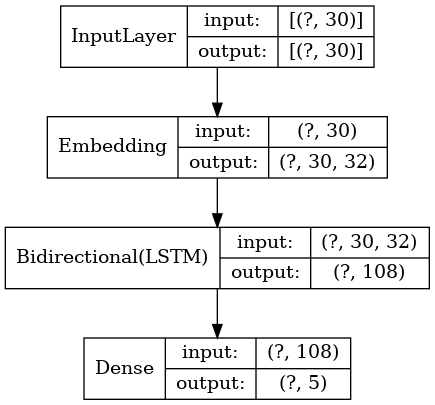

In [6]:

# Attempt to load already-existing model.
# Otherwise, build and train the model.
try:
    model = keras.models.load_model('models/EDNLP_BLSTM')
    print('EDNLP_BLSTM Model loaded.\n')
except:
    print('EDNLP_BLSTM Model not found at models/EDNLP_BLSTM. Building model.')
    # Model Structure
    model = Sequential(name='EDNLP_BLSTM')

    scaleFactor = 8
    embedOutput = 32

    lstmUnits = int(round(
        len(ednlp['tr']['Xp'])
        /
        (scaleFactor * (len(e_index) + embedOutput))
    ))

    print('Target Outputs for unidirectional LSTM Layer:',lstmUnits)

    model.add(Embedding(numWords, embedOutput, input_length=maxWordCount, name='embedding'))
    model.add(Bidirectional(LSTM(lstmUnits, dropout=0.1), name='blstm'))
    model.add(Dense(len(e_index), activation='sigmoid', name='dense'))

    model.get_layer('embedding')

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics=['accuracy'])

    #Model Training
    history =  model.fit(
        ednlp['tr']['Xp'], ednlp['tr']['y'],
        epochs=21,
        use_multiprocessing=True,
        validation_data=(ednlp['va']['Xp'], ednlp['va']['y'])
    )
    # Save model
    print('Saving model...\n')
    model.save('models/EDNLP_BLSTM')

print(model.summary())
plot_model(model, to_file='images/BLSTM_model.png', show_shapes=True, show_layer_names=False)


 # Testing BLSTM_EDNLP Model
 Plots a Confussion Matrix and generates a Classification report. Saves both.

63/63 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support
anger          0.860902  0.832727  0.846580   275.000
fear           0.780083  0.839286  0.808602   224.000
joy            0.914557  0.831655  0.871138   695.000
other          0.606498  0.746667  0.669323   225.000
sadness        0.902397  0.907057  0.904721   581.000
accuracy       0.845000  0.845000  0.845000     0.845
macro avg      0.812888  0.831478  0.820073  2000.000
weighted avg   0.853929  0.845000  0.847809  2000.000


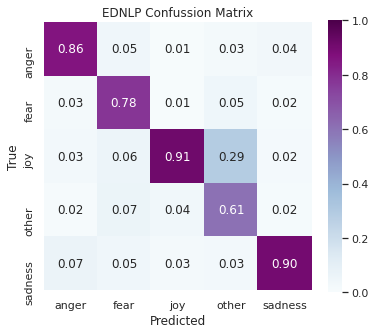

In [7]:

testPrediction = predictAndChoose(model, ednlp['te']['Xp'])

# Accuracy, Presicion, Recall, and F1-Score
report=classification_report(ednlp['te']['y'], testPrediction, target_names=e_index, output_dict=True)
report=pd.DataFrame(report).transpose()
report.to_csv('reports/ednlp.csv', float_format='%.2f')
print(report)

# Confussion Matrix
ednlp_cm=confusion_matrix(ednlp['te']['y'], testPrediction, normalize='pred')
plot_confussion_matrix(ednlp_cm, e_index, name='EDNLP', fmt='.2f', vmin=0, vmax=1)


 # EMHD Dataset
 Annotation of the MHD Dataset.
 Attempt to lad already existing EMHD file.
 Otherwise, anotate it from the MHD DataFrame.

In [8]:
eHeaders=['post', 'reply', 'post_emotion', 'reply_emotion']

# Attempt to lad already existing EMHD file.
# Otherwise, anotate it from the MHD DataFrame.
try:
    emhd = pd.read_csv('dataset/emotional_mental_health.csv')
    emhd = emhd.reset_index(drop=True)
    print('Emotionally annotated dataset (EMHD) loaded')
#Begin annotating MHD into EMHD
except:
    print('EMHD Not found at dataset/emotional_mental_health.csv. Contructing from MHD.')
    emhd = mhd
    for name, _ in mhd.iteritems():
        sys.stdout.write(f'Annotating column "{name}" with emotion...\n')
        start = time.time()
        treated = mhd[name].apply(nlpTreatment)  # First apply NLP treatment
        _, pSeq = sequencerPadder(treated, tokenizer) # Store padded sequences
        emhd[f'{name}_emotion'] = predictAndChoose(model, pSeq) # Predict and annotate
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" annotated. ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    emhd.to_csv('dataset/emotional_mental_health.csv', index=False)

dataFrameStatus(emhd)


Emotionally annotated dataset (EMHD) loaded
Dataframe shape: (162647, 4)
Number of post: 108328
Number of reply: 157816
Number of post_emotion: 5
Number of reply_emotion: 5
                                                     post  \
130274  after falling massively behind in school becau...   
53840   whats your story howd it happen and howd you f...   
76177   hey thank you for reaching out it is uncomfort...   
20417   when will society start to care about the fact...   
76251   definetly ive found that the best thing is let...   

                                                    reply  post_emotion  \
130274  congrats before you start i recommend checking...             1   
53840   ive been currently been undignoised with my bi...             1   
76177   thank you didnt expect this from to be honest ...             1   
20417         what does this have to do with gay marriage             3   
76251   i normally end you just walking out of class a...             4   

        r

 # EMHD Reports and Plots
 Plots and saves BarCount graphs and an interaction heatmap.

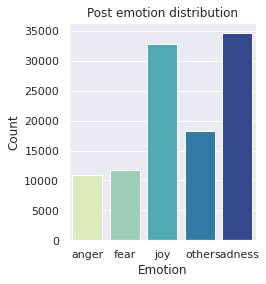

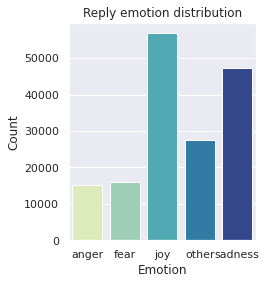

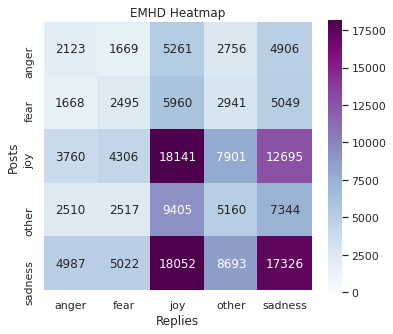

In [9]:

#Countplots
unique_posts_emhd = emhd.drop_duplicates(['post'])
plot_countbars(unique_posts_emhd,'post')
plot_countbars(emhd, 'reply')

#Heatmap
emhd_cm = confusion_matrix(emhd['post_emotion'], emhd['reply_emotion'], normalize=None)
plot_confussion_matrix(emhd_cm, e_index, name='EMHD', title='Heatmap', ylabel='Posts', xlabel='Replies', fmt='d', vmin=0)


 That was fun wasn't it?
 # :)